In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
traindf = pd.read_csv('../DATA/titanic/train.csv')

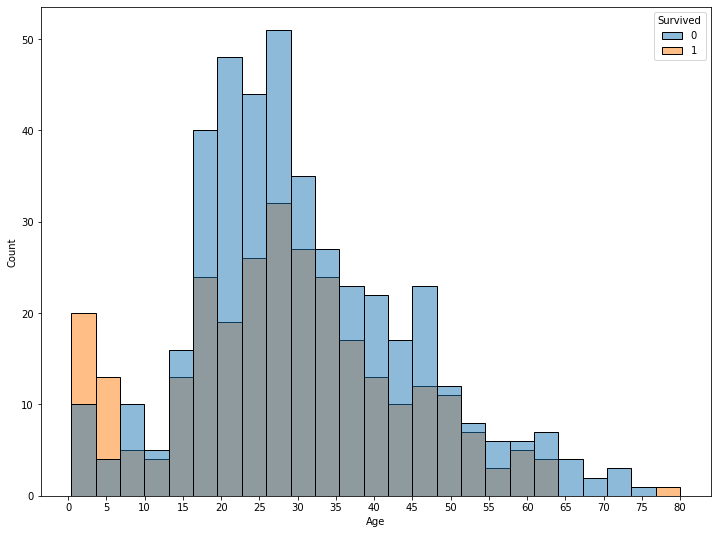

In [3]:
plt.figure(figsize=(12,9))
sns.histplot(x='Age', data=traindf, bins=25, hue='Survived')
plt.xticks(np.arange(0,85,5))
plt.show()

In [4]:
# Age Group shall be divided as follow:
# Age <= 5
# 5 < Age <=17
# 17 < Age <=35
# 35 < Age <=50
# 50 < Age <=65
# Age > 65

In [5]:
# Extract title from full name
traindf['Last_name'] = traindf['Name'].apply(lambda x: x.split(",")[0])
traindf['First_name'] = traindf['Name'].apply(lambda x: x.split(",")[1])
traindf['Title'] = traindf['First_name'].apply(lambda x: x.split(".")[0].strip())

In [11]:
test = traindf['Name'].apply(lambda x: x.split(","))

In [14]:
test[0][1]

' Mr. Owen Harris'

In [6]:
def fill_age(pclass, title, age):
    if pd.isnull(age):
        if title == 'Mr':
            if pclass == 1:
                return 40
            if pclass == 2:
                return 31
            if pclass ==3:
                return 26
        if title == 'Mrs':
            if pclass == 1:
                return 41.5
            if pclass == 2:
                return 32
            if pclass == 3:
                return 31
        if ((title == 'Miss') | (title == 'Ms')):
            if pclass == 1:
                return 30
            if pclass == 2:
                return 24
            if pclass == 3:
                return 18
        if title == 'Master':
            return 3.5
        if title == 'Dr':
            if pclass == 1:
                return 46.5
            if pclass == 2:
                return 38.5
    else:
        return age

In [7]:
# Title group:
# Nobleman -> Don, Jonkheer, Sir
# Noblewoman -> Lady, the Countess
# Mrs -> Mrs, Mme
# Miss -> Miss, Mlle, Ms
# Military -> Capt, Col, Major
# Master -> Master
# Mr -> Mr
# Rev -> Rev
# Dr -> Dr

In [8]:
def group_title(data):
    if (data == 'Don') | (data == 'Jonkheer') | (data=='Sir'):
        return 'Nobleman'
    if (data == 'Lady') | ("Countess" in data) | ("Dona" in data):
        return 'Noblewoman'
    if (data == 'Mme'):
        return 'Mrs'
    if (data == 'Mlle') | (data=='Ms'):
        return 'Miss'
    if any(x in data for x in ['Capt', 'Col', 'Major']):
        return 'Military'
    else:
        return data

In [9]:
traindf['Title_group'] = traindf.apply(lambda x: group_title(x['Title']), axis=1)

In [10]:
fillage = pd.DataFrame()
fillage['Age'] = traindf.apply(lambda x: fill_age(x['Pclass'], x['Title'], x['Age']), axis=1)
traindf['Age'] = fillage['Age']

<AxesSubplot:>

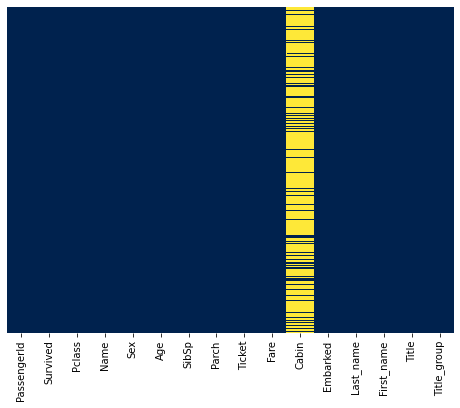

In [11]:
# Check filled data
plt.figure(figsize=(8,6))
sns.heatmap(traindf.isnull(), yticklabels=False, cbar=False, cmap='cividis')

In [12]:
test_ticket = pd.read_csv('../DATA/titanic/test.csv')
test_ticket = test_ticket[['PassengerId','Ticket']]
train_ticket = traindf[['PassengerId','Ticket']]

In [13]:
tickets = pd.concat([train_ticket, test_ticket], axis=0)

In [14]:
group_ticket = tickets.groupby('Ticket').count().reset_index()

In [15]:
group_ticket.columns = ['Ticket','Group_size']

In [16]:
group_ticket.head(10)

,Ticket,Group_size
0,110152,3
1,110413,3
2,110465,2
3,110469,1
4,110489,1
5,110564,1
6,110813,2
7,111163,1
8,111240,1
9,111320,1


In [17]:
#group_ticket['Single_ticket'] = group_ticket.apply(lambda df: 1 if df['Name'] == 1 else 0, axis=1)

In [18]:
traindf = pd.merge(traindf, group_ticket[['Ticket', 'Group_size']], how='inner', on='Ticket')

In [19]:
traindf['Family_size'] = 1 + traindf['SibSp'] + traindf['Parch']

In [20]:
# Passenger ID is equal to index. Drop PassengerId
traindf = traindf.drop('PassengerId', axis=1)

# Drop cabin column
traindf = traindf.drop('Cabin', axis=1)

# Drop last name, first name, name, title
traindf = traindf.drop(['Last_name','First_name','Name','Title','Ticket','Group_size','Family_size'],axis=1)

traindf = traindf.fillna('S')

In [21]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    object 
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    object 
 8   Title_group  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 69.6+ KB


In [22]:
traindf = pd.get_dummies(traindf, columns=['Sex','Embarked', 'Title_group','Pclass'], drop_first=True)

In [23]:
# train test split
from sklearn.model_selection import train_test_split

In [24]:
X = traindf.drop('Survived',axis=1)
y = traindf['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4821)

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [26]:
scale_features = ['Age', 'Fare', 'SibSp', 'Parch']
scaler.fit(X_train[scale_features])

MinMaxScaler()

In [27]:
X_train_ss = scaler.transform(X_train[scale_features])

In [28]:
X_train_ss = pd.DataFrame(X_train_ss, columns = scale_features, index=X_train.index)

In [29]:
X_train = pd.concat([X_train_ss, X_train.drop(scale_features, axis=1)], axis=1)

In [30]:
X_test_ss = scaler.transform(X_test[scale_features])
X_test_ss = pd.DataFrame(X_test_ss, columns=scale_features, index=X_test.index)
X_test = pd.concat([X_test_ss, X_test.drop(scale_features,axis=1)],axis=1)

In [31]:
from sklearn.linear_model import LogisticRegression

In [32]:
lrmodel = LogisticRegression(max_iter=10000)
lrmodel.fit(X_train, y_train)
lrmodel.score(X_test, y_test)

0.832089552238806

In [33]:
lr_preds = lrmodel.predict(X_test)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [35]:
from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier(n_estimators=128)

In [36]:
rfmodel.fit(X_train, y_train)
rfmodel.score(X_test, y_test)

0.7910447761194029

In [37]:
rf_preds = rfmodel.predict(X_test)

In [38]:
from sklearn.svm import SVC

In [39]:
svmodel = SVC()

In [40]:
svmodel.fit(X_train, y_train)
svm_preds = svmodel.predict(X_test)

In [41]:
svmodel.score(X_test, y_test)

0.835820895522388

In [42]:
from sklearn.model_selection import GridSearchCV

In [43]:
param_grid = {'C': [0.01, 0.1, 1, 10, 5, 15], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 5]}
gs = GridSearchCV(SVC(), param_grid=param_grid, verbose=3)

In [44]:
gs.fit(X_train, y_train)
gs.score(X_test, y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END ................................C=0.01, gamma=1; total time=   0.0s
[CV 2/5] END ................................C=0.01, gamma=1; total time=   0.0s
[CV 3/5] END ................................C=0.01, gamma=1; total time=   0.0s
[CV 4/5] END ................................C=0.01, gamma=1; total time=   0.0s
[CV 5/5] END ................................C=0.01, gamma=1; total time=   0.0s
[CV 1/5] END ..............................C=0.01, gamma=0.1; total time=   0.0s
[CV 2/5] END ..............................C=0.01, gamma=0.1; total time=   0.0s
[CV 3/5] END ..............................C=0.01, gamma=0.1; total time=   0.0s
[CV 4/5] END ..............................C=0.01, gamma=0.1; total time=   0.0s
[CV 5/5] END ..............................C=0.01, gamma=0.1; total time=   0.0s
[CV 1/5] END .............................C=0.01, gamma=0.01; total time=   0.0s
[CV 2/5] END .............................C=0.0

[CV 4/5] END ...............................C=10, gamma=0.01; total time=   0.0s
[CV 5/5] END ...............................C=10, gamma=0.01; total time=   0.0s
[CV 1/5] END ..............................C=10, gamma=0.001; total time=   0.0s
[CV 2/5] END ..............................C=10, gamma=0.001; total time=   0.0s
[CV 3/5] END ..............................C=10, gamma=0.001; total time=   0.0s
[CV 4/5] END ..............................C=10, gamma=0.001; total time=   0.0s
[CV 5/5] END ..............................C=10, gamma=0.001; total time=   0.0s
[CV 1/5] END .............................C=10, gamma=0.0001; total time=   0.0s
[CV 2/5] END .............................C=10, gamma=0.0001; total time=   0.0s
[CV 3/5] END .............................C=10, gamma=0.0001; total time=   0.0s
[CV 4/5] END .............................C=10, gamma=0.0001; total time=   0.0s
[CV 5/5] END .............................C=10, gamma=0.0001; total time=   0.0s
[CV 1/5] END ...............

0.8395522388059702

In [45]:
gs.best_params_

{'C': 0.1, 'gamma': 1}

In [46]:
gs_preds = gs.predict(X_test)

In [47]:
print(classification_report(y_test, gs_preds))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       167
           1       0.88      0.66      0.76       101

    accuracy                           0.84       268
   macro avg       0.85      0.80      0.82       268
weighted avg       0.85      0.84      0.83       268



In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [49]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [50]:
model = Sequential()
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [51]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

In [52]:
model.fit(x=X_train, y=y_train, epochs=250, callbacks=[early_stop], validation_data=(X_test, y_test))

Epoch 1/250
20/20 [==============================] - 2s 64ms/step - loss: 0.7438 - val_loss: 0.6862
Epoch 2/250
20/20 [==============================] - 0s 4ms/step - loss: 0.6895 - val_loss: 0.6727
Epoch 3/250
20/20 [==============================] - 0s 3ms/step - loss: 0.6759 - val_loss: 0.6571
Epoch 4/250
20/20 [==============================] - 0s 3ms/step - loss: 0.6502 - val_loss: 0.6121
Epoch 5/250
20/20 [==============================] - 0s 3ms/step - loss: 0.6257 - val_loss: 0.5616
Epoch 6/250
20/20 [==============================] - 0s 3ms/step - loss: 0.6170 - val_loss: 0.5306
Epoch 7/250
20/20 [==============================] - 0s 4ms/step - loss: 0.5682 - val_loss: 0.4997
Epoch 8/250
20/20 [==============================] - 0s 3ms/step - loss: 0.5432 - val_loss: 0.4831
Epoch 9/250
20/20 [==============================] - 0s 3ms/step - loss: 0.5574 - val_loss: 0.4715
Epoch 10/250
20/20 [==============================] - 0s 3ms/step - loss: 0.5524 - val_loss: 0.4677
Epoch 11

In [53]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

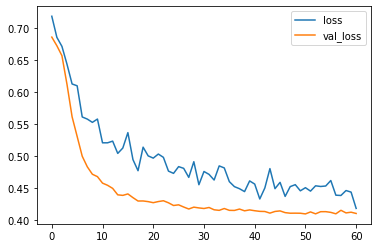

In [54]:
losses.plot()

In [55]:
ann_preds = (model.predict(X_test) > 0.5).astype("int32")

In [56]:
print('Artificial Neural Network Classification Report - Titanic Dataset')
print('\n')
print(confusion_matrix(y_test, ann_preds))
print(classification_report(y_test, ann_preds))

Artificial Neural Network Classification Report - Titanic Dataset


[[161   6]
 [ 39  62]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       167
           1       0.91      0.61      0.73       101

    accuracy                           0.83       268
   macro avg       0.86      0.79      0.81       268
weighted avg       0.85      0.83      0.82       268



In [57]:
print('Logistic Regression Classification Report - Titanic Dataset')
print('\n')
print(confusion_matrix(y_test, lr_preds))
print(classification_report(y_test, lr_preds))

Logistic Regression Classification Report - Titanic Dataset


[[148  19]
 [ 26  75]]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       167
           1       0.80      0.74      0.77       101

    accuracy                           0.83       268
   macro avg       0.82      0.81      0.82       268
weighted avg       0.83      0.83      0.83       268



In [58]:
print('Random Forests Classification Report - Titanic Dataset')
print('\n')
print(confusion_matrix(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

Random Forests Classification Report - Titanic Dataset


[[143  24]
 [ 32  69]]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       167
           1       0.74      0.68      0.71       101

    accuracy                           0.79       268
   macro avg       0.78      0.77      0.77       268
weighted avg       0.79      0.79      0.79       268



In [59]:
print('Support Vector Machine Classifier')
print(confusion_matrix(y_test, svm_preds))
print(classification_report(y_test, svm_preds))

Support Vector Machine Classifier
[[164   3]
 [ 41  60]]
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       167
           1       0.95      0.59      0.73       101

    accuracy                           0.84       268
   macro avg       0.88      0.79      0.81       268
weighted avg       0.86      0.84      0.83       268



In [60]:
#Prepare test dataset for submission to Kaggle
X_Val = pd.read_csv('../DATA/titanic/test.csv')
X_Val['Last_name'] = X_Val['Name'].apply(lambda x: x.split(",")[0])
X_Val['First_name'] = X_Val['Name'].apply(lambda x: x.split(",")[1])
X_Val['Title'] = X_Val['First_name'].apply(lambda x: x.split(".")[0].strip())

X_Val['Title_group'] = X_Val.apply(lambda x: group_title(x['Title']), axis=1)

fillage = pd.DataFrame([])
fillage['Age'] = X_Val.apply(lambda x: fill_age(x['Pclass'], x['Title'], x['Age']), axis=1)
X_Val['Age'] = fillage['Age']
X_Val.iloc[152, 8] = 12.46

X_Val['Family_size'] = 1 + X_Val['SibSp'] + X_Val['Parch']
X_Val = pd.merge(X_Val, group_ticket[['Ticket', 'Group_size']], how='inner', on='Ticket')
X_Val = X_Val.drop('Cabin', axis=1)

Submission = pd.DataFrame([])
Submission['PassengerId'] = X_Val['PassengerId']

X_Val = X_Val.drop(['Last_name','First_name','Name','Title','Ticket','PassengerId','Group_size','Family_size'],axis=1)

X_Val = pd.get_dummies(X_Val, columns=['Sex','Embarked', 'Title_group','Pclass'], drop_first=True)

X_Val['Title_group_Nobleman'] = 0

X_Val = X_Val.reindex(columns=X.columns)

In [61]:
X_Val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     418 non-null    float64
 1   SibSp                   418 non-null    int64  
 2   Parch                   418 non-null    int64  
 3   Fare                    418 non-null    float64
 4   Sex_male                418 non-null    uint8  
 5   Embarked_Q              418 non-null    uint8  
 6   Embarked_S              418 non-null    uint8  
 7   Title_group_Master      418 non-null    uint8  
 8   Title_group_Military    418 non-null    uint8  
 9   Title_group_Miss        418 non-null    uint8  
 10  Title_group_Mr          418 non-null    uint8  
 11  Title_group_Mrs         418 non-null    uint8  
 12  Title_group_Nobleman    418 non-null    int64  
 13  Title_group_Noblewoman  418 non-null    uint8  
 14  Title_group_Rev         418 non-null    ui

In [62]:
X_Val_ss = scaler.transform(X_Val[scale_features])
X_Val_ss = pd.DataFrame(X_Val_ss, columns=scale_features, index=X_Val.index)
X_Val = pd.concat([X_Val_ss, X_Val.drop(scale_features,axis=1)],axis=1)

In [63]:
ann_preds2 = (model.predict(X_Val) > 0.5).astype("int32")

In [64]:
rf_preds2 = rfmodel.predict(X_Val)

In [65]:
svm_preds2 = svmodel.predict(X_Val)

In [66]:
rf_sub = pd.DataFrame([])
rf_sub['PassengerId'] = Submission['PassengerId']
rf_sub['Survived'] = rf_preds2

In [67]:
svm_sub = pd.DataFrame([])
svm_sub['PassengerId'] = Submission['PassengerId']
svm_sub['Survived'] = svm_preds2

In [68]:
rf_sub.to_csv(r'C:\Users\elber\Desktop\RF_predictions.csv',index=False)

In [69]:
Submission['Survived'] = ann_preds2
Submission.to_csv(r'C:\Users\elber\Desktop\Titanic_submission.csv',index=False)

In [70]:
svm_sub.to_csv(r'C:\Users\elber\Desktop\SVM_predictions.csv',index=False)